Problem:\
Maximise: $f(x_1, x_2) = 3x_1 + 5x_2\\$
Subject to:\
    $2x_1 + 3x_2 <= 12\\$
    $2x_1 + x_2 <= 8\\$
    $x_1, x_2 >= 0$

In [1]:
import pickle
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

mlpObjectives = mlpResults["mlpObjectives"]
mlpAllLosses = mlpResults["mlpAllLosses"]
mlpTimes = mlpResults["mlpTimes"]
mlpSummary = mlpResults["mlpSummary"]
mlpAllCoordinates = mlpResults["mlpAllCoordinates"]
mlpAllEuclideanAccuracies = mlpResults["mlpAllEuclideanAccuracies"]
mlpAllObjectiveAccuracies = mlpResults["mlpAllObjectiveAccuracies"]

kanObjectives = kanResults["kanObjectives"]
kanAllLosses = kanResults["kanAllLosses"]
kanTimes = kanResults["kanTimes"]
kanSummary = kanResults["kanSummary"]
kanAllCoordinates = kanResults["kanAllCoordinates"]
kanAllEuclideanAccuracies = kanResults["kanAllEuclideanAccuracies"]
kanAllObjectiveAccuracies = kanResults["kanAllObjectiveAccuracies"]


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.optimize import linprog
from kan import * 

In [3]:
#maximise 3x1 + 5x2 is the same as minimise -3x1 - 5x2
objectiveCoeffs = [-3, -5]

constraintMatrix = [[2, 3], [2, 1]]
constraintBounds = [12, 8]
variableBounds = [(0, None), (0, None)]

startTime = time.time()
result = linprog(objectiveCoeffs, A_ub=constraintMatrix, b_ub=constraintBounds, bounds=variableBounds, method="highs")
endTime = time.time()
xAnalytical = result.x
objAnalytical = 3 * xAnalytical[0] + 5 * xAnalytical[1]
timeAnalytical = endTime - startTime

print(f"Analytical Solution: {xAnalytical}")
print(f"Objective Value: {objAnalytical}")
print(f"Convergence Time: {timeAnalytical}")

Analytical Solution: [0. 4.]
Objective Value: 20.0
Convergence Time: 0.02054286003112793


In [4]:
def objectiveFunction(x):
    return 3 * x[:, 0] + 5 * x[:, 1]

def constraint1(x): return 2 * x[0] + 3 * x[1] <= 12
def constraint2(x): return 2 * x[0] + x[1] <= 8
def nonNegativity(x): return (x[0] >= 0) and (x[1] >= 0)

#generate samples which the neural network will use to learn
def generateFeasibleSamples(nSamples=1000):
    samples = []
    for i in range(nSamples * 2):
        x = torch.rand(2) * 6
        if constraint1(x) and constraint2(x) and nonNegativity(x):
            samples.append(x)
        if len(samples) >= nSamples:
            break
    data = torch.stack(samples)
    targets = objectiveFunction(data)
    return data, targets


In [ ]:
#MLP structure with 2 variables in input and 1 in output
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

#the amount of training loops, in other words the amount of times we will run the model
mlpNRuns = 5
#the amount of epochs within each training loop
mlpEpochs = 20000

mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for i in range(mlpNRuns):
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    #initialising model and optimiser
    mlpModel = MLP()
    optimiser = optim.Adam(mlpModel.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    mlpRunLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    mlpStartTime = time.time()

    #training loop
    for epoch in range(mlpEpochs):
        optimiser.zero_grad()
        predictions = mlpModel(xTrain)
        loss = criterion(predictions, yTrain)
        loss.backward()
        optimiser.step()
        mlpRunLosses.append(loss.item())

        with torch.no_grad():
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            bestX = xTrain[bestPrediction]
            mlpBestVal = predictions[bestPrediction].item()
            mlpRunCoordinates.append(bestX)
            mlpBestX1 = bestX[0].item()
            mlpBestX2 = bestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    mlpEndTime = time.time()
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)
    mlpAllLosses.append(mlpRunLosses)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2
    })

    print(f"Run {i+1}: Best x1 = {mlpBestX1:.4f}, x2 = {mlpBestX2:.4f} => Objective = {mlpBestVal:.4f}, Loss = {mlpRunLosses[-1]:.4f}")

#extracting metrics
mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} +- {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} +- {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s +- {np.std(mlpTimes):.4f}s")



Run 1: Best x1 = 0.2190, x2 = 3.8309 => Objective = 19.8041, Loss = 0.0000
Run 2: Best x1 = 0.4540, x2 = 3.6797 => Objective = 19.7568, Loss = 0.0000
Run 3: Best x1 = 0.2360, x2 = 3.8364 => Objective = 19.8903, Loss = 0.0000
Run 4: Best x1 = 0.1194, x2 = 3.9115 => Objective = 19.9211, Loss = 0.0000
Run 5: Best x1 = 0.1916, x2 = 3.8703 => Objective = 19.9132, Loss = 0.0002
Mean Objective Value: 19.8571 +- 0.0652
Mean Final Loss:      0.0000 +- 0.0001
Mean Time:            99.2848s +- 5.8213s


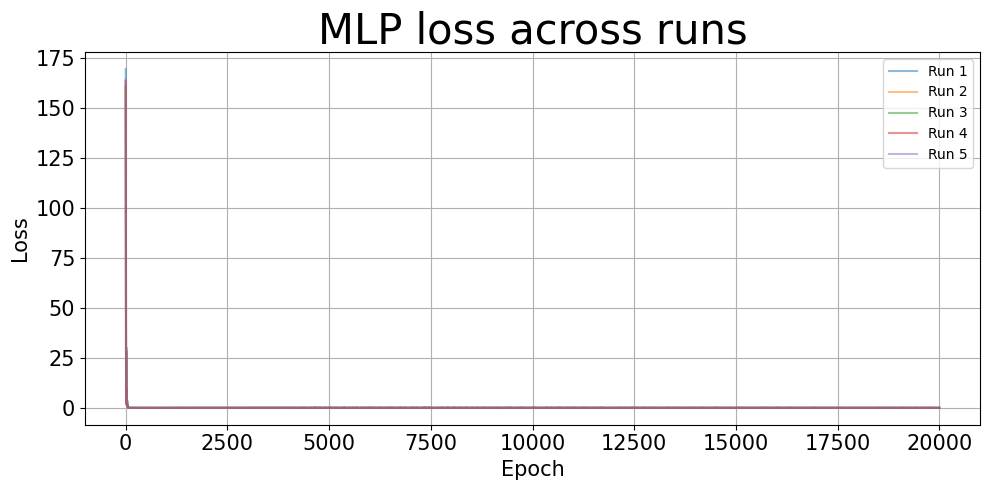

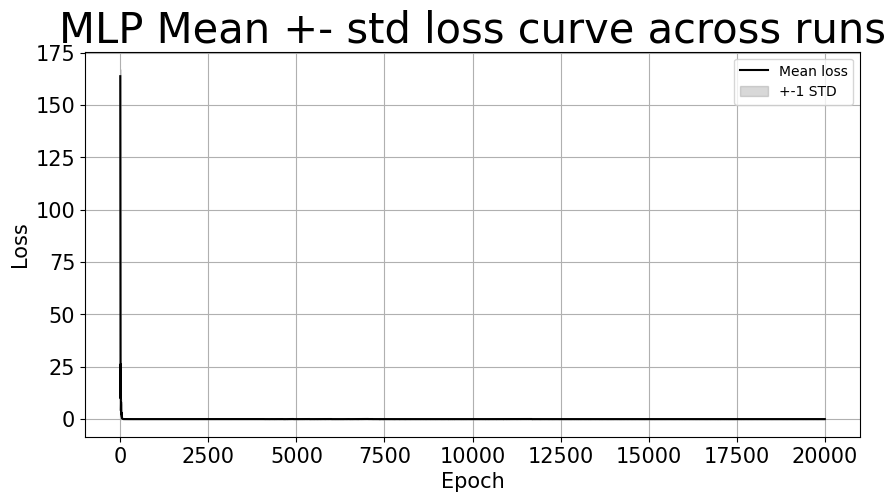

In [48]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and standard deviation of losses over all runs
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(20000), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP Mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

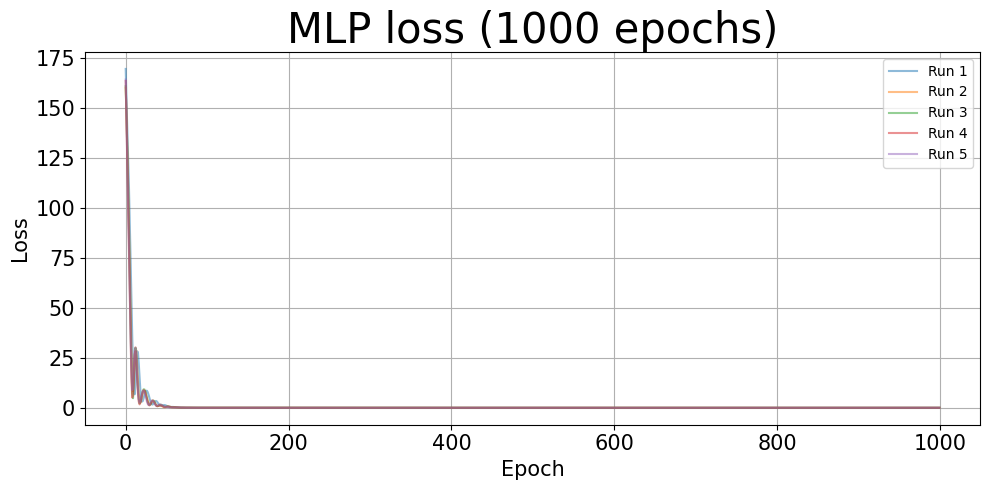

In [49]:
#loss graph restricted to 1000 epochs
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP loss (1000 epochs)", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

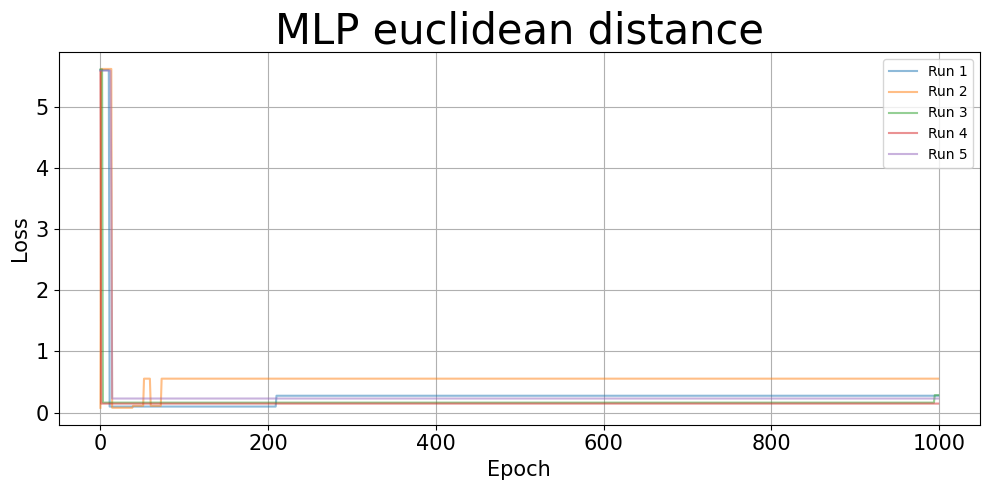

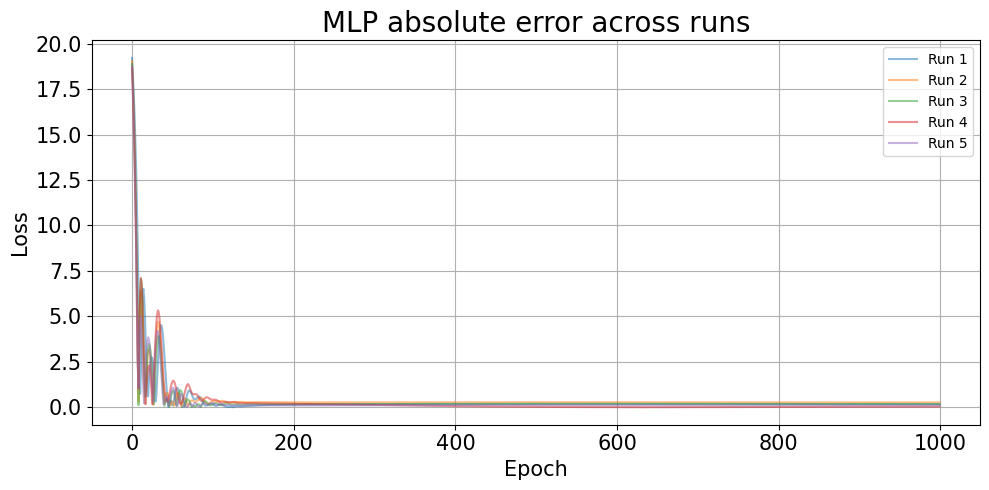

In [ ]:
#euclidean distance over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#absolute error over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP absolute error across runs", fontsize=20)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


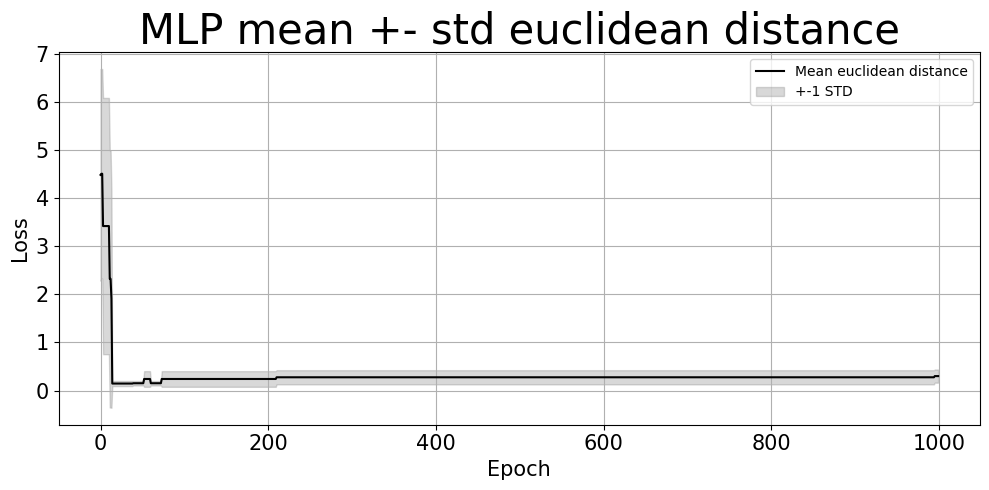

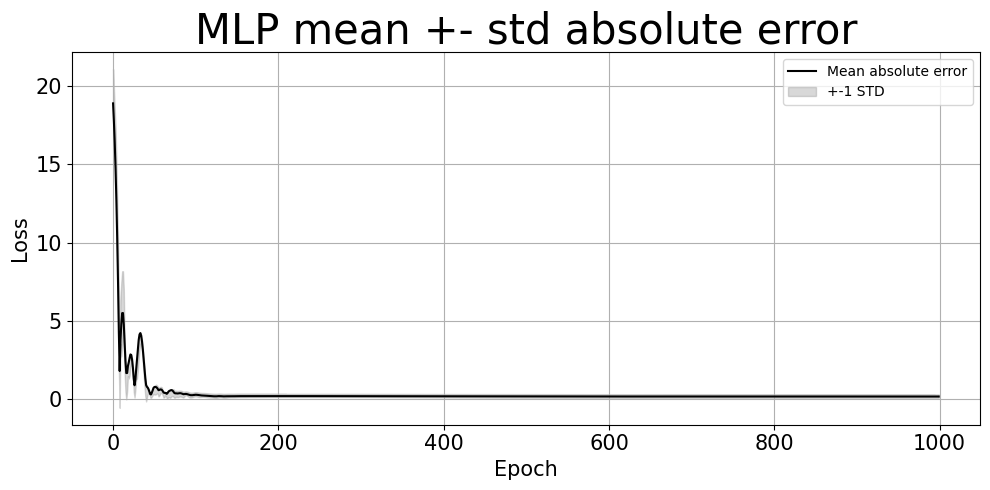

In [52]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("MLP mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

for i in range(kanNRuns):
    torch.manual_seed(i)
    np.random.seed(i)
    xTrain, yTrain = generateFeasibleSamples(5000)
    yTrain = yTrain.unsqueeze(1)

    #initialising model and optimiser
    kanModel = KAN(width=[2, 4, 4, 1], grid=5, k=3, seed=i+1)
    optimiser = optim.Adam(kanModel.parameters(), lr=0.01)
    runLosses = []
    startTime = time.time()
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []

    for epoch in range(kanEpochs):
        if epoch == 500:
            kanModel.refine(10)
            
        kanModel.train()
        optimiser.zero_grad()
        predictions = kanModel(xTrain)
        loss = torch.mean((predictions - yTrain) ** 2)
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

    #refine step halfway
    # kanModel.refine(10)
    # for epoch in range(500):
    #     kanModel.train()
    #     optimiser.zero_grad()
    #     predictions = kanModel(xTrain)
    #     loss = torch.mean((predictions - yTrain) ** 2)
    #     loss.backward()
    #     optimiser.step()
    #     runLosses.append(loss.item())
    
        with torch.no_grad():
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            bestX = xTrain[bestPrediction]
            bestVal = predictions[bestPrediction].item()
            kanRunCoordinates.append(bestX)
            bestX1 = bestX[0].item()
            bestX2 = bestX[1].item()
            euclideanDistance = torch.norm(torch.tensor([bestX1, bestX2]) - torch.tensor([xAnalytical[0], xAnalytical[1]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)
          
    endTime = time.time()
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanAllLosses.append(runLosses)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": bestX1,
        "x2": bestX2
    })

    print(f"Run {i+1}: Best x1 = {bestX1:.4f}, x2 = {bestX2:.4f} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

#metrics
kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 1: Best x1 = 0.1404, x2 = 3.9042 => Objective = 20.0595, Loss = 0.0018
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 2: Best x1 = 0.0636, x2 = 3.9228 => Objective = 19.7615, Loss = 0.0033
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 3: Best x1 = 0.0979, x2 = 3.9311 => Objective = 19.8400, Loss = 0.0022
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 4: Best x1 = 0.3634, x2 = 3.7576 => Objective = 19.8173, Loss = 0.0010
checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1
Run 5: Best x1 = 0.0053, x2 = 3.9959 => Objective = 20.0332, Loss = 0.0016
Mean Objective Value: 19.9023 +- 0.1206
Mean Final Loss:      0.0020 +- 0.0008
Mean Time:            120.9632s +- 1.6633s


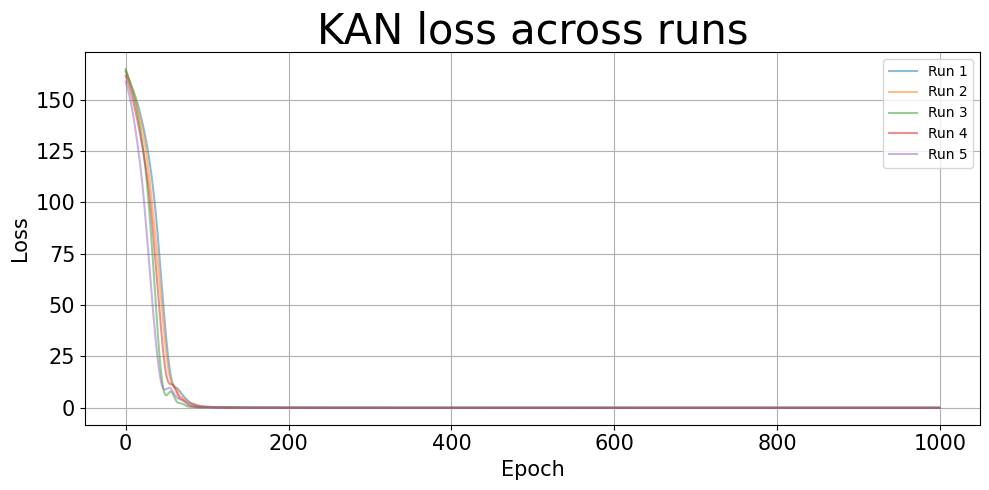

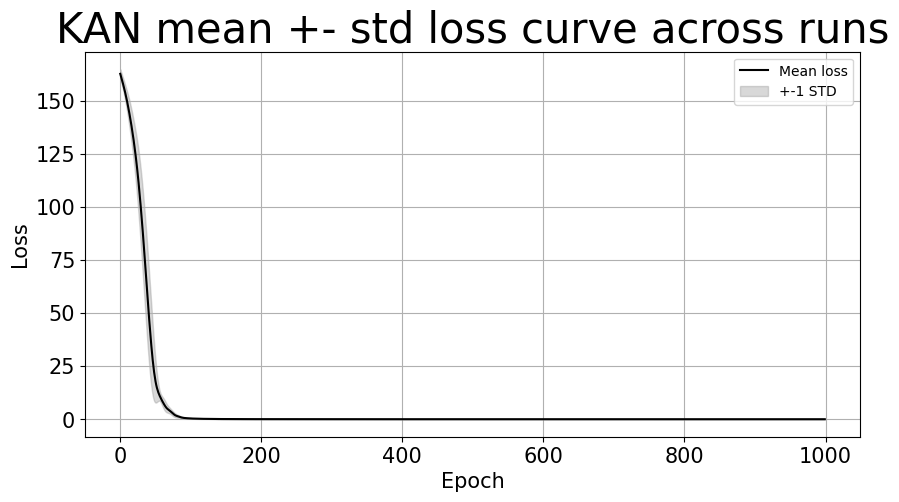

In [53]:
#loss graph
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN loss across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#graph of mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean loss", color='black')
plt.fill_between(range(1000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std loss curve across runs", fontsize=30)
plt.grid(True)
plt.legend()
plt.show()

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss

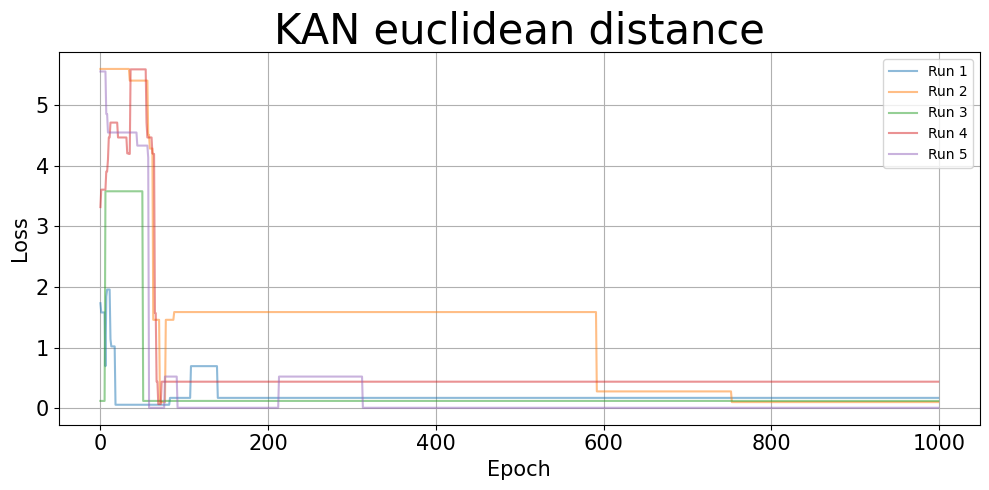

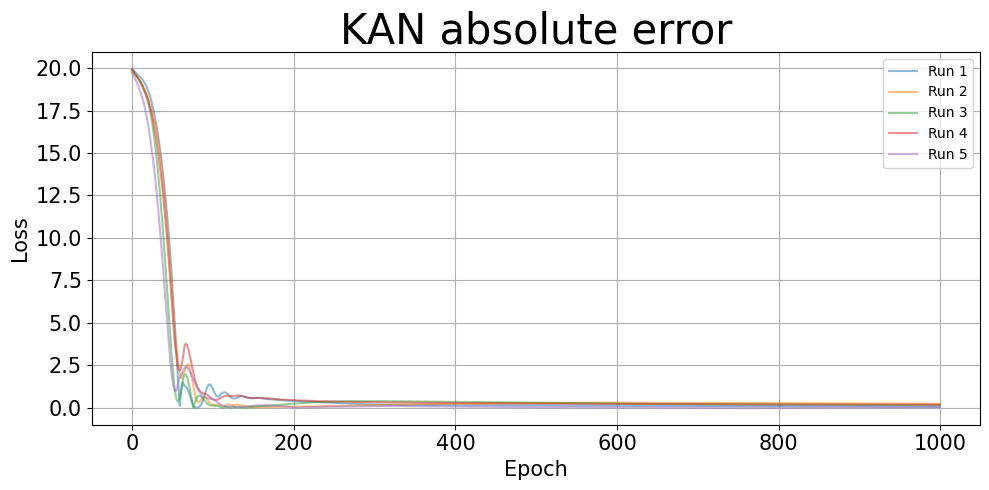

In [37]:
#kan euclidean distance across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#kan absolute error across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



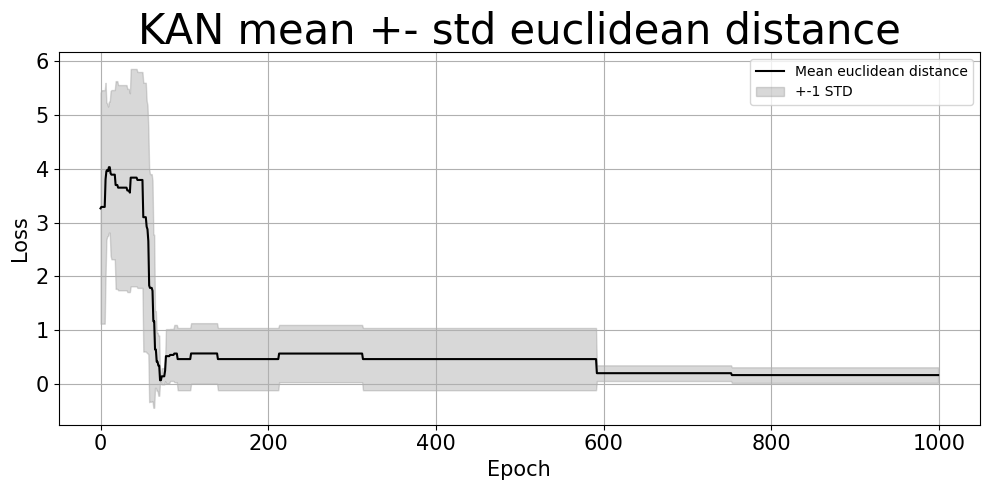

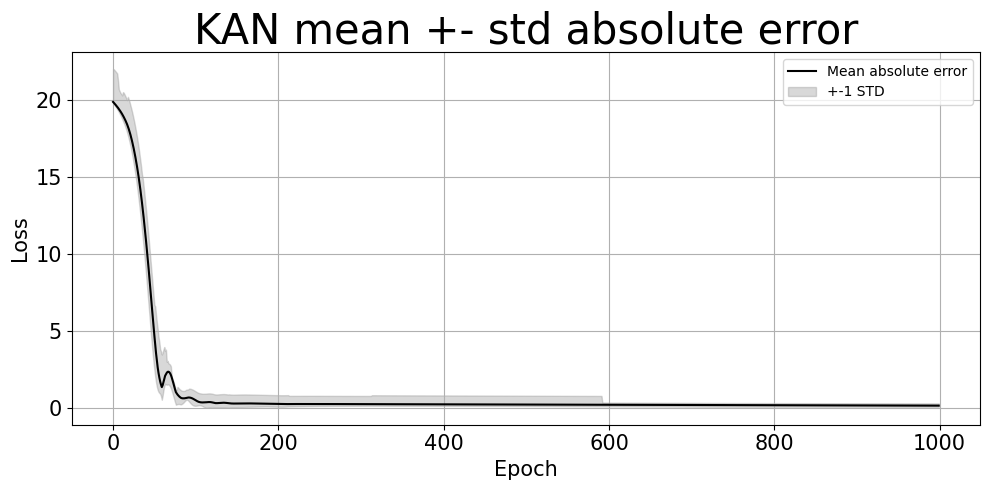

In [54]:
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

#mean and std of euclidean distance
plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy[:1000], label="Mean euclidean distance", color='black')
plt.fill_between(range(1000), kanMeanEuclideanAccuracy[:1000] - kanStdEuclideanAccuracy[:1000], kanMeanEuclideanAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std euclidean distance", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

#mean and std of absolute error
plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy[:1000], label="Mean absolute error", color='black')
plt.fill_between(range(1000), kanMeanObjectiveAccuracy[:1000] - kanStdObjectiveAccuracy[:1000], kanMeanObjectiveAccuracy[:1000] + kanStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.yticks(fontsize=15)
plt.title("KAN mean +- std absolute error", fontsize=30)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [60]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [41]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)


In [42]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,19.857101,19.902323
1,Std Objective Value,0.065154,0.120625
2,Best Objective Value,19.921148,20.059498
3,Mean Final Loss,0.000045,0.001972
4,Std Final Loss,0.000059,0.000771
5,Mean Time (s),99.284823,120.963200
6,Std Time (s),5.821296,1.663264
7,Mean Convergence Epoch,11148.600000,970.800000
8,Std Convergence Epoch,7354.543564,6.305553
9,Model Parameters,4417.000000,604.000000


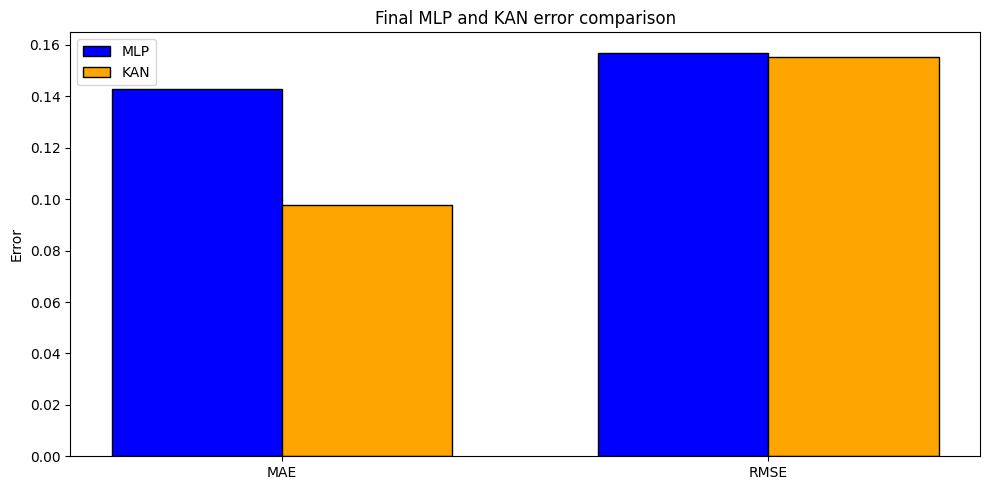

In [44]:
mlpMeanAbsError = abs(np.mean(mlpObjectives) - objAnalytical)
kanMeanAbsError = abs(np.mean(kanObjectives) - objAnalytical)
mlpRMSE = np.sqrt(np.mean((np.array(mlpObjectives) - objAnalytical)**2))
kanRMSE = np.sqrt(np.mean((np.array(kanObjectives) - objAnalytical)**2))

metrics = ['MAE', 'RMSE']
mlpErrors = [mlpMeanAbsError, mlpRMSE]
kanErrors = [kanMeanAbsError, kanRMSE]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, mlpErrors, width, label='MLP', color='blue', edgecolor='black')
plt.bar(x + width/2, kanErrors, width, label='KAN', color='orange', edgecolor='black')

plt.ylabel('Error')
plt.title('Final MLP and KAN error comparison')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_17488\2367243651.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


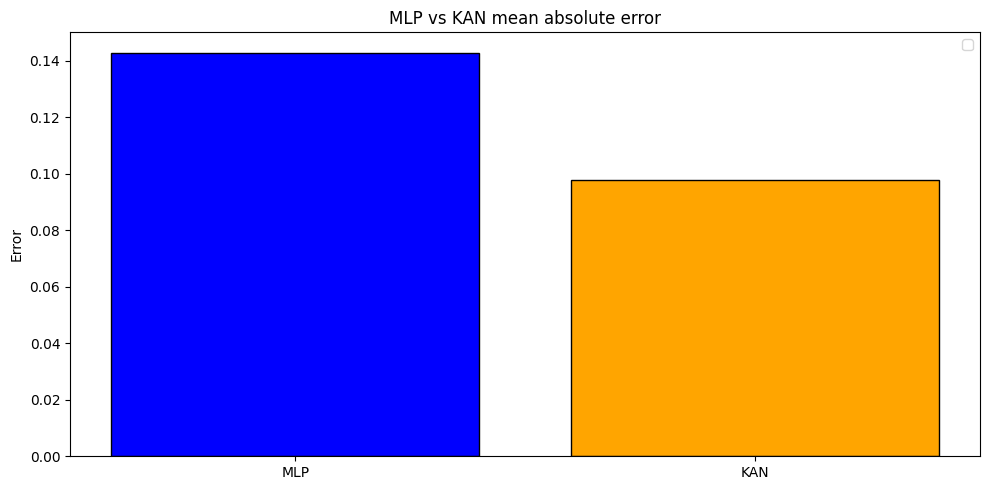

In [57]:
plt.figure(figsize=(10, 5))
plt.bar("MLP", mlpMeanAbsError, color='blue', edgecolor='black')
plt.bar("KAN", kanMeanAbsError, color='orange', edgecolor='black')
plt.ylabel('Error')
plt.title("MLP vs KAN mean absolute error")
plt.legend()
plt.tight_layout()
plt.show()


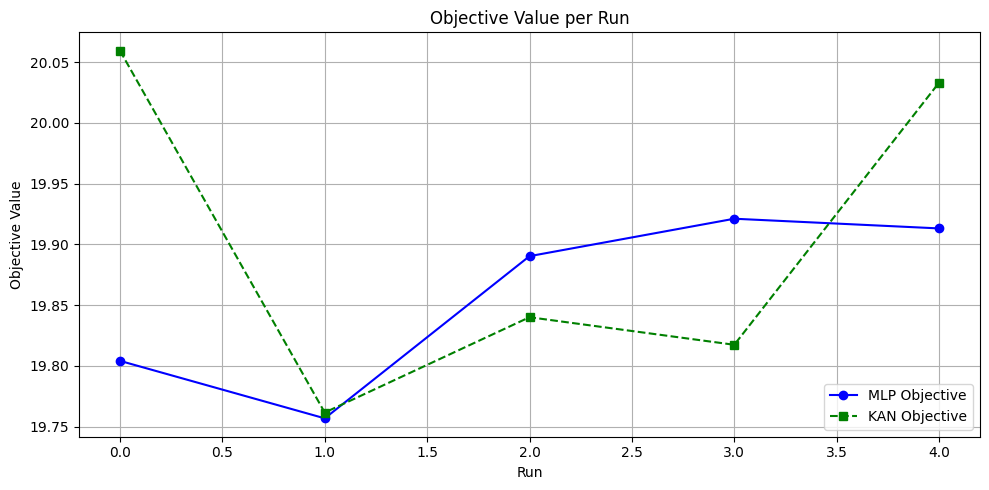

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

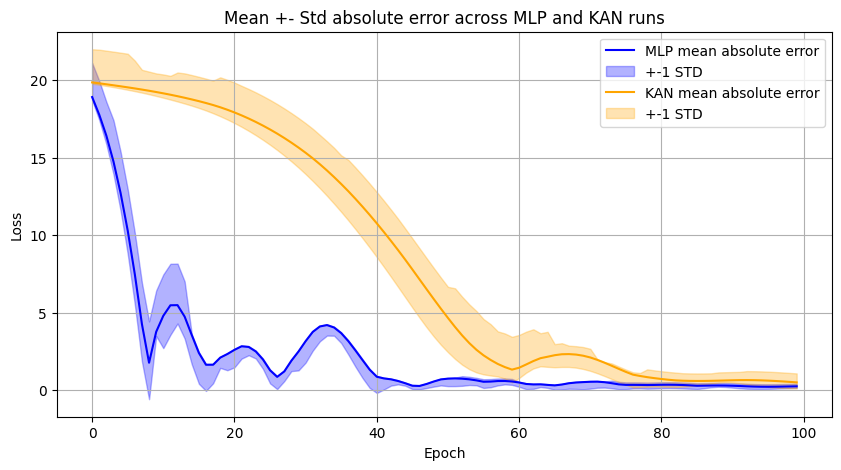

In [100]:
#absolute error comparison
start = 0
epochLimit = 100
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

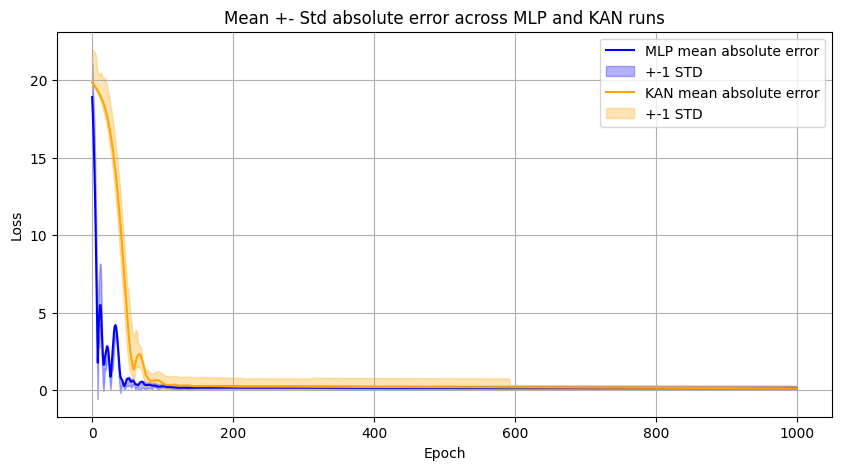

In [99]:
#absolute error comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

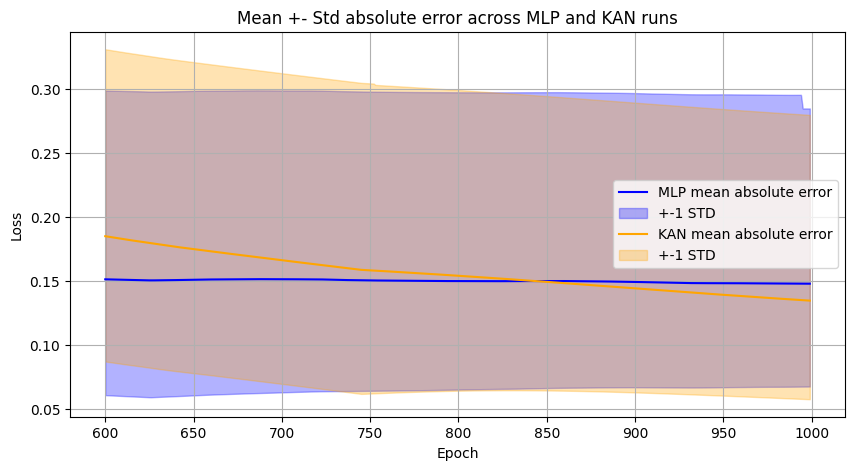

In [110]:
#absolute error comparison
start = 600
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanObjectiveAccuracy[start:epochLimit], label="MLP mean absolute error", color='blue')
plt.fill_between(epochs, mlpMeanObjectiveAccuracy[start:epochLimit] - mlpStdObjectiveAccuracy[start:epochLimit], mlpMeanObjectiveAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanObjectiveAccuracy[start:epochLimit], label="KAN mean absolute error", color='orange')
plt.fill_between(epochs, kanMeanObjectiveAccuracy[start:epochLimit] - kanStdObjectiveAccuracy[start:epochLimit], kanMeanObjectiveAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std absolute error across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

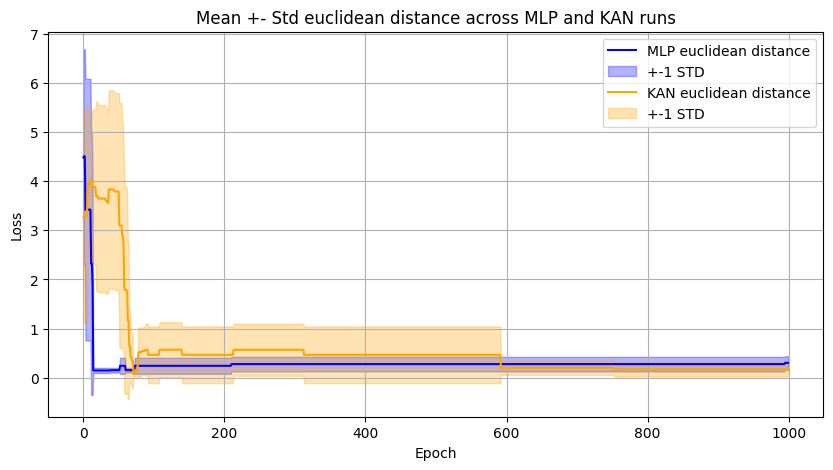

In [101]:
#euclidean distance comparison
start = 0
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

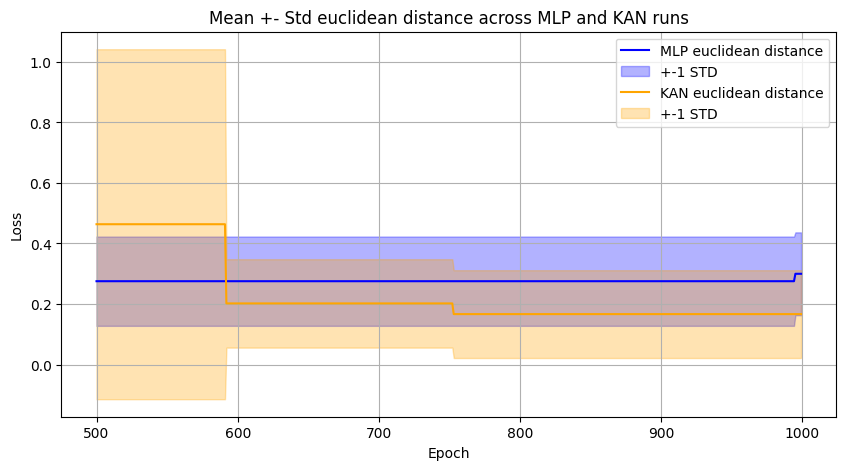

In [102]:
#euclidean distance comparison
start = 500
epochLimit = 1000
epochs = np.arange(start, epochLimit)
plt.figure(figsize=(10, 5))
plt.plot(epochs, mlpMeanEuclideanAccuracy[start:epochLimit], label="MLP euclidean distance", color='blue')
plt.fill_between(epochs, mlpMeanEuclideanAccuracy[start:epochLimit] - mlpStdEuclideanAccuracy[start:epochLimit], mlpMeanEuclideanAccuracy[start:epochLimit] + mlpStdEuclideanAccuracy[start:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(epochs, kanMeanEuclideanAccuracy[start:epochLimit], label="KAN euclidean distance", color='orange')
plt.fill_between(epochs, kanMeanEuclideanAccuracy[start:epochLimit] - kanStdEuclideanAccuracy[start:epochLimit], kanMeanEuclideanAccuracy[start:epochLimit] + kanStdEuclideanAccuracy[start:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std euclidean distance across MLP and KAN runs")
plt.grid(True)
plt.legend()
plt.show()

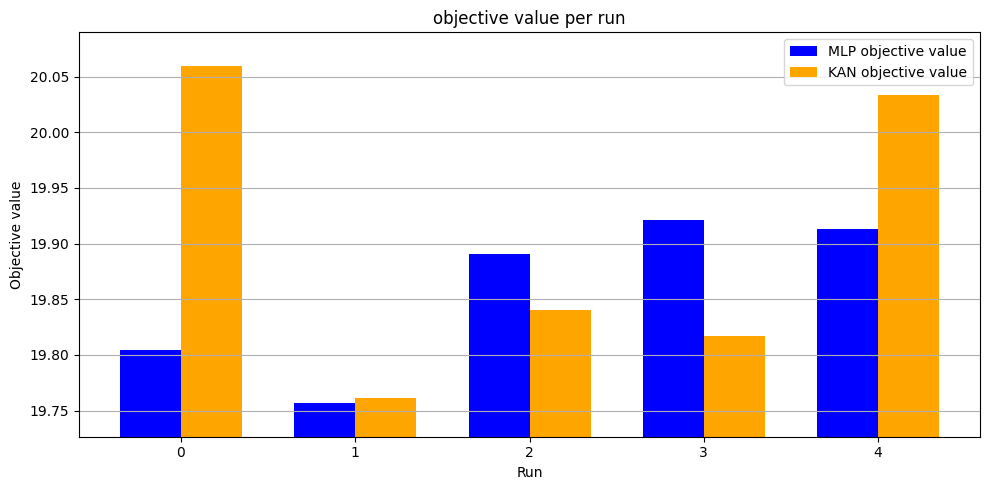

In [103]:
#bar graph of objective values in each run
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP objective value", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN objective value", color='orange')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

[3476, 13756, 17746, 19329, 1436] [978, 974, 961, 966, 975]


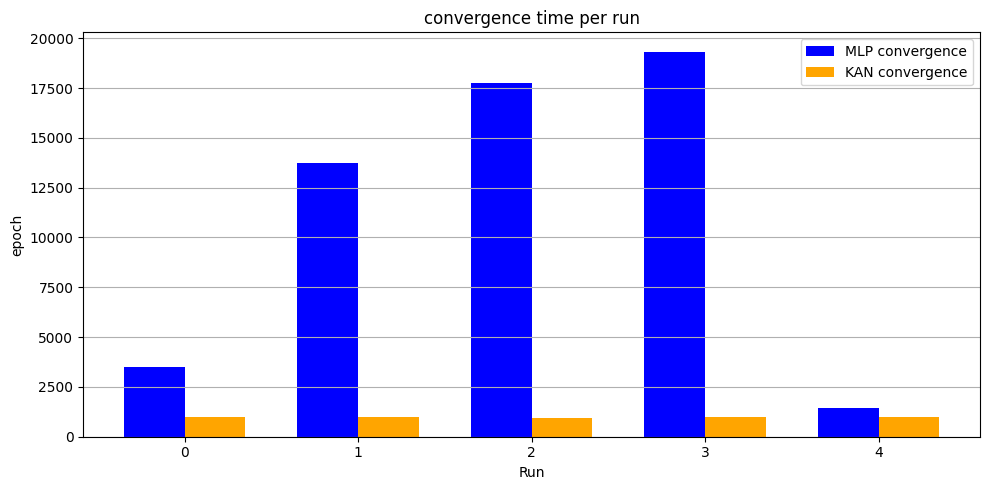

In [ ]:
#bar chart of convergence time
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

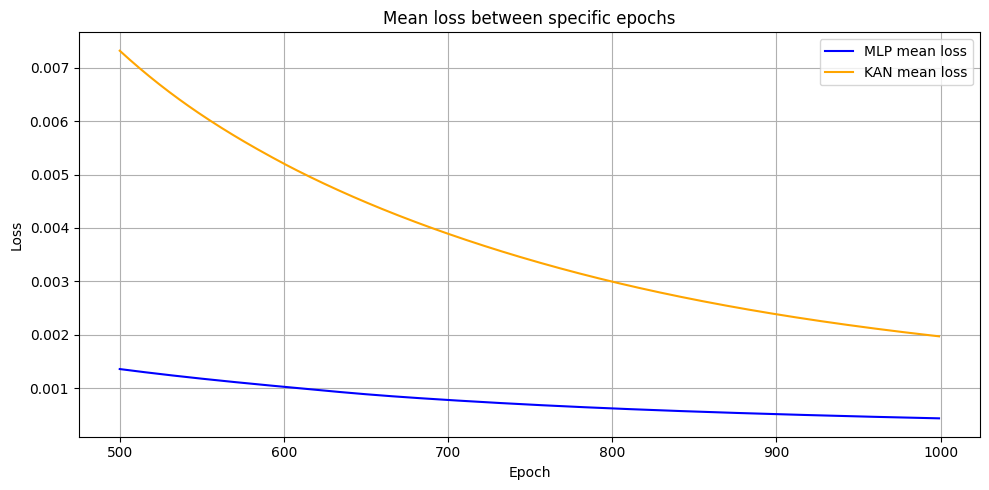

In [113]:
startEpoch = 500
endEpoch = 1000
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
kanMeanLoss = np.mean(kanLossArray, axis=0)
epochs = np.arange(len(mlpMeanLoss)) 

plt.figure(figsize=(10, 5))
plt.plot(epochs[startEpoch:endEpoch], mlpMeanLoss[startEpoch:endEpoch], label="MLP mean loss", color='blue')
plt.plot(epochs[startEpoch:endEpoch], kanMeanLoss[startEpoch:endEpoch], label="KAN mean loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Mean loss between specific epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


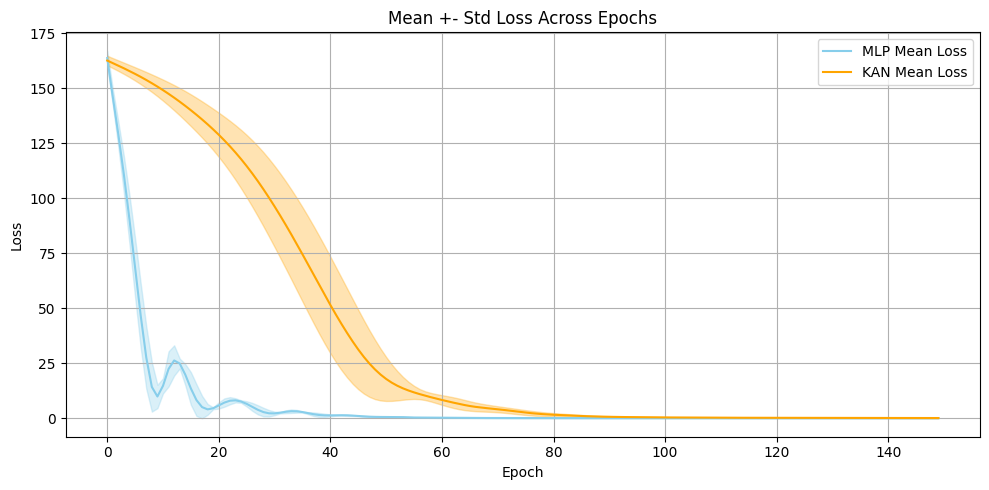

In [75]:
start = 0
end = 150
mlpLossArray = np.array(mlpAllLosses)[start:end]
kanLossArray = np.array(kanAllLosses)[start:end]

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[start:end]
mlpStdLoss = np.std(mlpLossArray, axis=0)[start:end]

kanMeanLoss = np.mean(kanLossArray, axis=0)[start:end]
kanStdLoss = np.std(kanLossArray, axis=0)[start:end]

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


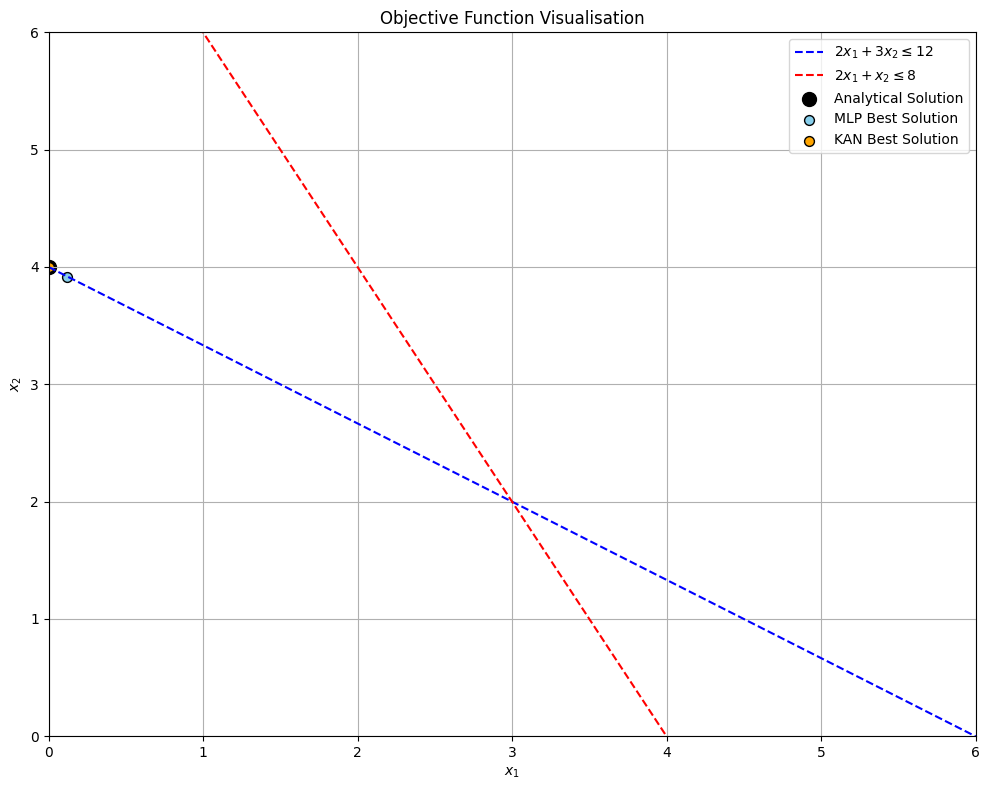

In [ ]:
def objective(x1, x2):
    return 3 * x1 + 5 * x2

def feasible(x1, x2):
    return (2*x1 + 3*x2 <= 12) & (2*x1 + x2 <= 8) & (x1 >= 0) & (x2 >= 0)

x1_vals = np.linspace(0, 6, 200)
x2_vals = np.linspace(0, 6, 200)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = objective(X1, X2)
mask = feasible(X1, X2)

mlpBestX = (mlpAllCoordinates[np.argmax(mlpObjectives)][-1][0], mlpAllCoordinates[np.argmax(mlpObjectives)][-1][1])
kanBestX = (kanAllCoordinates[np.argmax(kanObjectives)][-1][0], kanAllCoordinates[np.argmax(kanObjectives)][-1][1])

plt.figure(figsize=(10, 8))
#constraints
plt.plot(x1_vals, (12 - 2*x1_vals) / 3, label=r"$2x_1 + 3x_2 \leq 12$", linestyle='--', color='blue')
plt.plot(x1_vals, (8 - 2*x1_vals), label=r"$2x_1 + x_2 \leq 8$", linestyle='--', color='red')
#best solutions
plt.scatter(*xAnalytical, color='black', s=100, label='Analytical Solution', edgecolor='black')
plt.scatter(*mlpBestX, color='skyblue', s=50, label='MLP Best Solution', edgecolor='black')
plt.scatter(*kanBestX, color='orange', s=50, label='KAN Best Solution', edgecolor='black')

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Objective Function Visualisation")
plt.legend()
plt.grid(True)
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()
plt.show()


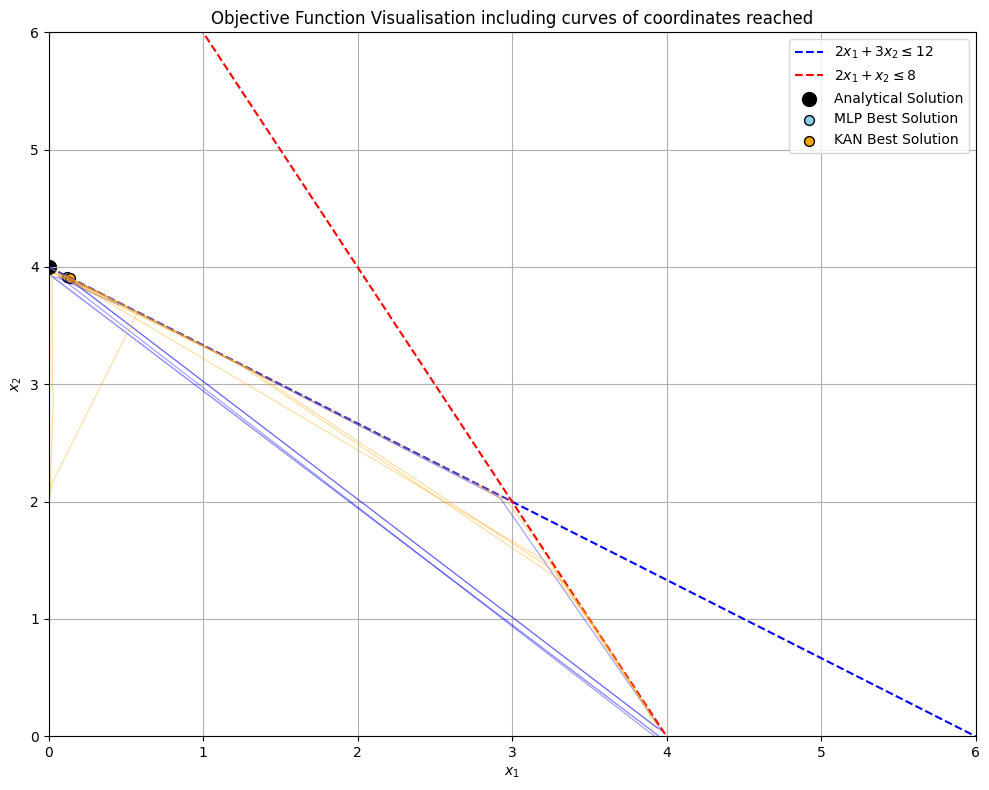

In [12]:
def objective(x1, x2):
    return 3 * x1 + 5 * x2

def feasible(x1, x2):
    return (2*x1 + 3*x2 <= 12) & (2*x1 + x2 <= 8) & (x1 >= 0) & (x2 >= 0)

x1_vals = np.linspace(0, 6, 200)
x2_vals = np.linspace(0, 6, 200)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = objective(X1, X2)
mask = feasible(X1, X2)

mlpBestX = (mlpAllCoordinates[np.argmax(mlpObjectives)][-1][0], mlpAllCoordinates[np.argmax(mlpObjectives)][-1][1])
kanBestX = (kanAllCoordinates[np.argmax(kanObjectives)][-1][0], kanAllCoordinates[np.argmax(kanObjectives)][-1][1])

plt.figure(figsize=(10, 8))
#constraints
plt.plot(x1_vals, (12 - 2*x1_vals) / 3, label=r"$2x_1 + 3x_2 \leq 12$", linestyle='--', color='blue')
plt.plot(x1_vals, (8 - 2*x1_vals), label=r"$2x_1 + x_2 \leq 8$", linestyle='--', color='red')

#mlp path taken
for runCoords in mlpAllCoordinates:
    runCoords = np.array(runCoords)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='blue', linewidth=0.8)

#kan path taken
for runCoords in kanAllCoordinates:
    runCoords = np.array(runCoords)
    plt.plot(runCoords[:,0],runCoords[:,1], alpha=0.4, color='orange', linewidth=0.8)


#best solutions
plt.scatter(*xAnalytical, color='black', s=100, label='Analytical Solution', edgecolor='black')
plt.scatter(*mlpBestX, color='skyblue', s=50, label='MLP Best Solution', edgecolor='black')
plt.scatter(*kanBestX, color='orange', s=50, label='KAN Best Solution', edgecolor='black')

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Objective Function Visualisation including curves of coordinates reached")
plt.legend()
plt.grid(True)
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.tight_layout()
plt.show()
